In [34]:
## This notebook has been created for Analytics Vidhya hackathon for Computer Vision:
##  https://datahack.analyticsvidhya.com/contest/janatahack-computer-vision-hackathon/#LeaderBoard
## Binary Classification (Emergency and Non Emergency dataset)


import sys
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.utils import to_categorical
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
%pylab inline

# Time Keeper
import timeit
start = timeit.default_timer()

# Just to check If GPU is available.
tf.test.gpu_device_name()


Populating the interactive namespace from numpy and matplotlib


'/device:GPU:0'

In [35]:
# This cell will keep all the PATHS used.

DATA_DIR = '/content/sample_data/data/'

TRAIN_DIR = '/content/sample_data/data/train/'

TRAIN_EMERGENCY = '/content/sample_data/data/train/1_emergency/'

TRAIN_NON_EMERGENCY = '/content/sample_data/data/train/0_nonemergency/'

TEST_PATH = '/content/sample_data/data/test_root/test/'



In [36]:
# Data Exploratioon => To check if all the images are of same sizes.

import os
from PIL import Image 

folder_images = "/content/sample_data/data/train/emer/_TO_STOP_THIS_CELL"
size_images = dict()

for dirpath, _, filenames in os.walk(folder_images):
    print("How many execute")
    for path_image in filenames:
        image = os.path.abspath(os.path.join(dirpath, path_image))
        with Image.open(image) as img:
            width, heigth = img.size
            size_images[path_image] = {'width': width, 'heigth': heigth}
            if width != 224 or heigth != 224:
              print(width,heigth,path_image)
            else:
              sys.stdout.write('-')

#print(size_images)

In [37]:
# define CNN model

def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.25))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.3))
	model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.22))
	model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.25))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	#opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
	return model



In [38]:
# plot diagnostic learning curves

def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.show()
 
	# Lets save the csv file for later analysis.
	new_dict = history.history
	df = pd.DataFrame(new_dict)
	df.to_csv("epoch_trends.csv", index=False) # write to csv


Found 1318 images belonging to 2 classes.
{'0_nonemergency': 0, '1_emergency': 1}
Found 328 images belonging to 2 classes.
Epoch 1/200
 - 20s - loss: 1.2133 - accuracy: 0.5857 - val_loss: 0.6448 - val_accuracy: 0.6189
Epoch 2/200
 - 20s - loss: 0.6269 - accuracy: 0.6753 - val_loss: 0.6338 - val_accuracy: 0.7012
Epoch 3/200
 - 19s - loss: 0.5943 - accuracy: 0.7223 - val_loss: 0.8286 - val_accuracy: 0.7500
Epoch 4/200
 - 20s - loss: 0.5907 - accuracy: 0.7155 - val_loss: 0.4328 - val_accuracy: 0.7165
Epoch 5/200
 - 19s - loss: 0.5645 - accuracy: 0.7223 - val_loss: 0.4649 - val_accuracy: 0.7134
Epoch 6/200
 - 20s - loss: 0.5427 - accuracy: 0.7564 - val_loss: 0.3776 - val_accuracy: 0.7866
Epoch 7/200
 - 20s - loss: 0.5064 - accuracy: 0.7701 - val_loss: 0.3849 - val_accuracy: 0.8049
Epoch 8/200
 - 19s - loss: 0.5216 - accuracy: 0.7564 - val_loss: 0.4382 - val_accuracy: 0.7927
Epoch 9/200
 - 20s - loss: 0.4761 - accuracy: 0.7769 - val_loss: 0.3847 - val_accuracy: 0.7774
Epoch 10/200
 - 19s - 

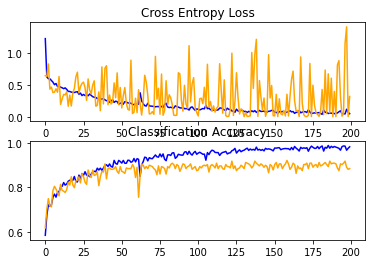

In [45]:
# run the model pipeline for evaluating a model. Use Image Augmentation for normalizing images.
def model_pipeline():
  # define model
  model = define_model()
  
  # create data generators
  
  datagen = ImageDataGenerator(validation_split=0.2,
                               rescale=1.0/255.0, 
                               width_shift_range=0.1, 
                               height_shift_range=0.1,
                               horizontal_flip=True
                               )
  
  train_generator = datagen.flow_from_directory(
                              TRAIN_DIR, 
                              subset='training',
                              color_mode="rgb", 
                              class_mode='binary',
                              shuffle=True,
                              batch_size=32,
                              target_size=(224, 224),
                              seed=123
    )
  
  # Its always good idea to print and check labels of train class
  labels = (train_generator.class_indices)
  print(labels)

  val_generator = datagen.flow_from_directory(
                              TRAIN_DIR,
                              subset='validation',
                              color_mode="rgb", 
                              class_mode='binary',
                              shuffle=True,
                              batch_size=32,
                              target_size=(224, 224),
                              seed=123
    )

  # Fit model
  history = model.fit_generator(train_generator, 
                                steps_per_epoch=len(train_generator),
                                validation_data=val_generator, 
                                validation_steps=len(val_generator), 
                                epochs=200, # Lets test Epoch from 50 to 500
                                verbose=2
                                )
  # Lets save the model as Hierarchical Data Format ( H5 )
  model.save('final_model.h5')
  
  # Plotting learning curves
  summarize_diagnostics(history)

# entry point, run the test harness
model_pipeline()

In [46]:
# make a prediction for test image.

model = load_model('final_model.h5')

# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(224, 224))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 224, 224, 3)
	# center pixel data
	img = img.astype('float32')
	return img

# load an image and predict the class
def run_example(pic):
	# load the image
	img = load_image(pic)
 
	# predict the class
	result = model.predict(img)
	return int(result[0])



In [47]:
def show_test_image(pic):
  img = cv2.imread(pic)
  img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img_cvt)
  ttl = run_example(pic)
  plt.title(ttl)
  plt.show()

In [48]:
# entry point, run the example

testdf = pd.read_csv(DATA_DIR+"test.csv")

testdf

,image_names
0,1960.jpg
1,668.jpg
2,2082.jpg
3,808.jpg
4,1907.jpg
...,...
701,674.jpg
702,1027.jpg
703,447.jpg
704,2176.jpg


In [55]:
# Run all the images in the loop and print for some random samples in test.

df = pd.DataFrame(columns=['image_names','emergency_or_not'])
test_img_name = testdf['image_names'].tolist()
for i,photo in enumerate(test_img_name):
  pred = run_example(TEST_PATH+photo)
  #print(i,photo,pred)
  df.loc[i] = [photo,pred]
print(df.emergency_or_not.value_counts())
df

0    437
1    269
Name: emergency_or_not, dtype: int64


,image_names,emergency_or_not
0,1960.jpg,0
1,668.jpg,1
2,2082.jpg,0
3,808.jpg,1
4,1907.jpg,0
...,...,...
701,674.jpg,1
702,1027.jpg,0
703,447.jpg,1
704,2176.jpg,0


In [51]:
# Lets bundle the predition for submission, Dont forget to increate the file counter to avoid overwriting.
CURRENT_SUBMISSION = 26
df.to_csv("Subimission_"+str(CURRENT_SUBMISSION)+".csv", index=False)

stop = timeit.default_timer()
print('Time: ', stop - start)

Time:  4906.034180239999


In [ ]:
1+1

#  Data Exploration and post mortem analysis 

In [ ]:
# Post Mortem analysis for Non Emergency Predictions.
from tqdm import tqdm
from keras.preprocessing import image
from keras.models import load_model

loaded_model = load_model("final_model.h6")
# loaded_model.summary()
# gc.collect()
dir_images = ("/content/sample_data/data/train/0_nonemergency/")
df_train = pd.read_csv("/content/drive/My Drive/ComputerVisionHackathon/train.csv")
df_train = df_train[(df_train["emergency_or_not"] == 0)]
images_name_list = df_train['image_names'].tolist()
train_image = []
#for i in tqdm(range(df_train.shape[0])):
    
for i,item in enumerate(images_name_list):
    #print(i,dir_images + str(item))
      try:
        img = image.load_img(dir_images +str(item), color_mode = "rgb")
      except FileNotFoundError:
        print('File does not exist : ',dir_images +str(item))
      img = image.img_to_array(img)
      img = img/255
      train_image.append(img)
    
    #print(train_image)
X = np.array(train_image)
y_pred = loaded_model.predict_classes(X)
df_train['prediction'] = y_pred
df_train_accuracy = df_train.groupby(['emergency_or_not', 'prediction']).size().reset_index(name='num_images')
df_train_accuracy['perc_images'] = 100*df_train_accuracy['num_images']/df_train_accuracy['num_images'].sum()
df_train_accuracy.head()
df_issues = df_train[(df_train['prediction'] != df_train['emergency_or_not'])]
# df_issues.head()
#os.chdir(dir_base)
df_issues.to_csv('df_issues_nonemer.csv', header=True, index=False)
df_issues


In [ ]:
# Post Mortem analysis for Emergency Predictions.

dir_images = ("/content/sample_data/data/train/1_emergency/")
df_train = pd.read_csv("/content/drive/My Drive/ComputerVisionHackathon/train.csv")
df_train = df_train[(df_train["emergency_or_not"] == 1)]
images_name_list = df_train['image_names'].tolist()
train_image = []
#for i in tqdm(range(df_train.shape[0])):
    
for i,item in enumerate(images_name_list):
    print(i,dir_images + str(item))
    try:
      img = image.load_img(dir_images +str(item), color_mode = "rgb")
    except FileNotFoundError:
      img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
    #print(train_image)
X = np.array(train_image)
y_pred = loaded_model.predict_classes(X)
df_train['prediction'] = y_pred
df_train_accuracy = df_train.groupby(['emergency_or_not', 'prediction']).size().reset_index(name='num_images')
df_train_accuracy['perc_images'] = 100*df_train_accuracy['num_images']/df_train_accuracy['num_images'].sum()
df_train_accuracy.head()
df_issues = df_train[(df_train['prediction'] != df_train['emergency_or_not'])]
# df_issues.head()
#os.chdir(dir_base)
df_issues.to_csv('df_issues_emer.csv', header=True, index=False)
df_issues


# **These are the pre processing to find duplicate images**

In [ ]:
import hashlib
#from scipy.misc import imread, imresize, imshow
from cv2 import imread
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
def file_hash(filename):
    with open(filename,'rb') as f:
        return md5(f.read()).hexdigest()

os.getcwd()
#os.chdir('/content/drive/My Drive/ComputerVisionHackathon/images')
os.chdir('/content/sample_data/uniqueimages/')
os.getcwd()

files_list = os.listdir('.')
print (len(files_list))

duplicates=[]
hash_keys=dict()
image_dict=dict()
for index, filename in enumerate(os.listdir('.')):
    if os.path.isfile(filename):
        with open(filename, 'rb') as f:
            filehash = hashlib.md5(f.read()).hexdigest()
        if filehash not in hash_keys:
            hash_keys[filehash]=[]
            hash_keys[filehash].append(filename)
        else:
            duplicates.append((index,hash_keys[filehash]))
            hash_keys[filehash].append(filename)

#print(duplicates)
print(hash_keys)

In [ ]:
# Data Exploration to identify duplicates and if prediction was class is different for duplicates.
import sys
df_train = pd.read_csv(DATA_DIR+"train.csv")
df_train.head()
for i in hash_keys:
  if len(hash_keys[i]) > 1:
    print("")
    print(hash_keys[i])
    emerOrNot=100
    for img in hash_keys[i]:
       new_emerOrNot = df_train.loc[df_train['image_names']==img,"emergency_or_not"].iloc[0]
       if emerOrNot == 100:
         emerOrNot = new_emerOrNot
       elif emerOrNot != new_emerOrNot:
         print("-------------- C O N F L I C T --------------")
       sys.stdout.write(str(df_train.loc[df_train['image_names']==img,"emergency_or_not"].iloc[0]))
       sys.stdout.write('_')
       sys.stdout.write(img)
       sys.stdout.write(" - ")
       #print(df_train.loc[df_train['image_names']==img,"emergency_or_not"].iloc[0])

In [ ]:
df_train = pd.read_csv("/content/drive/My Drive/ComputerVisionHackathon/train.csv")
image_to_delete = []
for i in hash_keys:
  just_for_print_del=[]
  noofitems = len(hash_keys[i])
  if noofitems > 1:
    fig=plt.figure(figsize=(10, 10))
    columns = noofitems
    count=1
    emerOrNot=100
    for img in hash_keys[i]:


      new_emerOrNot = df_train.loc[df_train['image_names']==img,"emergency_or_not"].iloc[0]
      if emerOrNot == 100:
        emerOrNot = new_emerOrNot
      elif emerOrNot != new_emerOrNot:
        print(emerOrNot,"-------------- C O N F L I C T --------------",new_emerOrNot)
        image_to_delete.append(img)
        just_for_print_del.append(img)
      else:
        image_to_delete.append(img)
        just_for_print_del.append(img)
      #sys.stdout.write(str(df_train.loc[df_train['image_names']==img,"emergency_or_not"].iloc[0]))
      #sys.stdout.write('_')
      #sys.stdout.write(img)
      #sys.stdout.write(" - ")
      img_title = str(new_emerOrNot)+'_'+str(img)
      try:
        fig.add_subplot(1, columns, count)
        plt.title(img_title)
        plt.imshow(imread(img))
      except OSError as e:
        continue
      count=count+1
    plt.show()
    print(just_for_print_del)
print(image_to_delete)

In [ ]:
#Replacing 54.jpg with 2029. as it is correctly categorised as an emergency vehicle
for index,item in enumerate(image_to_delete):
  if item == "54.jpg":
    position_to_replace=index
    print(index,item)
image_to_delete[position_to_replace]='2029.jpg'
print(image_to_delete[position_to_replace])

In [ ]:
!ls /content/sample_data/uniqueimages/ | wc -l
os.getcwd()
#os.chdir('/content/drive/My Drive/ComputerVisionHackathon/images')
os.chdir('/content/sample_data/uniqueimages/')
os.getcwd()

for index in image_to_delete:
    os.remove(index)
!ls /content/sample_data/uniqueimages/ | wc -l


In [ ]:
len(image_to_delete)

In [ ]:
df_train = pd.read_csv("/content/drive/My Drive/ComputerVisionHackathon/train.csv")
df_train.head()

df_train = df_train[(df_train["emergency_or_not"] == 1)]
emeregency_list = df_train['image_names'].tolist()

for item in emeregency_list:
  if item in image_to_delete:
    continue
  else:
    item_to_move='/content/sample_data/uniqueimages/'+str(item)
    print(item_to_move)
    !cp $item_to_move /content/sample_data/data/train/1_emergency/

In [ ]:
df_train = pd.read_csv("/content/drive/My Drive/ComputerVisionHackathon/train.csv")
df_train.head()

df_train = df_train[(df_train["emergency_or_not"] == 0)]
non_emeregency_list = df_train['image_names'].tolist()

for count,item in enumerate(non_emeregency_list):
  if item in image_to_delete:
    print(count,'----ESCAPE-----',item_to_move)
    continue
  else:
    item_to_move='/content/sample_data/uniqueimages/'+str(item)
    print(count,item_to_move)
    !cp $item_to_move /content/sample_data/data/train/0_nonemergency/

In [ ]:
import pandas as pd

df = pd.read_csv("/content/epoch_trends.csv")
df_loss = df[["val_loss","loss"]]
df_loss1 = df_loss1[-50:]
df_loss1.plot();

df_accuracy = df[["val_accuracy","accuracy"]]
df_accuracy1 = df_accuracy[-50:]
df_accuracy1.plot();

In [ ]:
df_loss = df[["val_loss","loss"]]
df_loss1 = df_loss[-100:]
df_loss1 = df_loss1.head(50)
df_loss1.plot();

df_accuracy = df[{"val_accuracy","accuracy"}]
df_accuracy1 = df_accuracy[-100:]
df_accuracy1 = df_accuracy1.head(50)
df_accuracy1.plot();

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from cv2 import imread

df = pd.read_csv("/content/sample_data/Subimission_15.csv")
TEST_PATH='/content/sample_data/test/'

emergency_cases = df[(df["emergency_or_not"] == 1)]
emergency_cases = emergency_cases['image_names'].tolist()
count=1
fig=plt.figure(figsize=(12, 12))
for pic in emergency_cases:
  
  try:
    fig.add_subplot(1, 2, count)
    plt.title(pic)
    plt.imshow(imread(TEST_PATH+str(pic)))
  except OSError as e:
    print(pic)
    continue
  if count == 2:
    count = 1
    plt.show()
    fig=plt.figure(figsize=(12, 12))
  else:
    count= count+1
    